<a href="https://colab.research.google.com/github/Ilya-Sed/mipt_Beeline/blob/main/roberta_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# прикрутим драйв

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# считываем данные

import pandas as pd

# Try reading the CSV file while specifying the delimiter and handling bad lines
try:
    data = pd.read_csv('/content/drive/MyDrive/MIPT/hackaton_result_dataset 2.csv', sep=';', on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

data.drop('Unnamed: 4', inplace=True, axis=1)
data.drop('audio_path', inplace=True, axis=1)


# отлично, теперь у нас есть чистая дата, добавим ппризнак и попробуем найти кореляцию

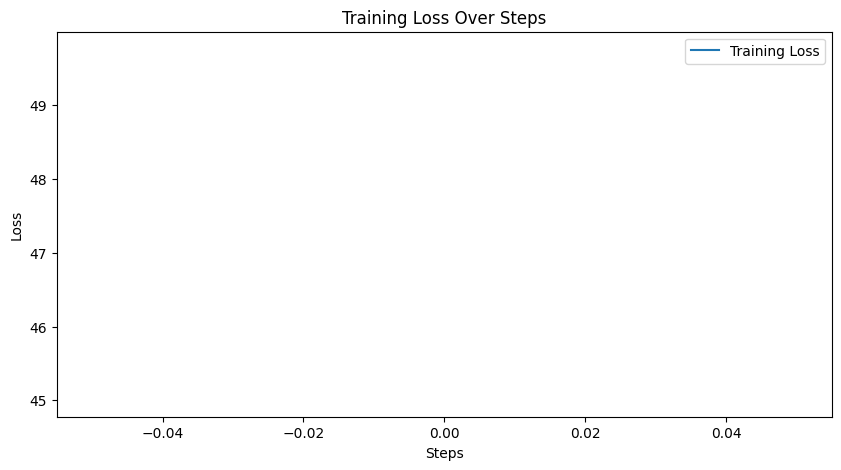

Epoch: 1, Step: 2, Loss: 29.9326171875
Epoch: 1, Step: 3, Loss: 20.690418243408203
Epoch: 1, Step: 4, Loss: 16.837690353393555
Epoch: 1, Step: 5, Loss: 14.688414573669434


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, XLMRobertaTokenizer, XLMRobertaForMaskedLM
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Предполагаем, что данные содержат тексты в формате списка строк
texts = list(data['human_markup'])

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512, mlm_probability=0.15):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mlm_probability = mlm_probability

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = inputs['input_ids'].clone()

        # Маскировка части токенов
        probability_matrix = torch.full(inputs['input_ids'].shape, self.mlm_probability)
        special_tokens_mask = self.tokenizer.get_special_tokens_mask(inputs['input_ids'], already_has_special_tokens=True)
        probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        inputs['input_ids'][masked_indices] = self.tokenizer.mask_token_id

        return inputs

# Настройка
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
dataset = TextDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

model = XLMRobertaForMaskedLM.from_pretrained('xlm-roberta-base')
model.train()

# Настройка оптимизатора
optimizer = AdamW(model.parameters(), lr=5e-5)

# Устройство для вычислений (GPU или CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Сохранение данных по loss
loss_mask_bert = []

# Функция для обновления графика
def update_plot(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Steps')
    plt.legend()
    plt.show()

# Процесс дообучения
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0
    for step, batch in enumerate(dataloader):
        # Переносим данные на устройство
        inputs = {key: val.to(device) for key, val in batch.items()}

        # Получаем выходы модели
        outputs = model(**inputs)
        loss = outputs.loss

        # Обратное распространение ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Очистка кэша после каждого шага
        torch.cuda.empty_cache()

        step_loss = loss.item()
        epoch_loss += step_loss
        loss_mask_bert.append(step_loss)

        print(f"Epoch: {epoch + 1}, Step: {step + 1}, Loss: {step_loss}")

        # Обновление графика каждые 10 шагов
        if step % 10 == 0:
            update_plot(loss_mask_bert)

    epoch_loss /= len(dataloader)
    print(f"Epoch: {epoch + 1}, Average Loss: {epoch_loss}")

# Сохранение дообученной модели
model.save_pretrained('./fine_tuned_xlm_roberta')
tokenizer.save_pretrained('./fine_tuned_xlm_roberta')

# Финальное построение графика изменения loss
update_plot(loss_mask_bert)
